Potential TODO:
- Prediction Website


- Work on refining best models
- Visualising some predictions
- Visualising feature importance for the models

In [112]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from tabulate import tabulate

from sklearn.preprocessing import RobustScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [113]:
modelling_df = pd.read_csv('Dataset/output_dataset.csv')

In [114]:
# Convert 'country', 'account_currency', 'Trading_Method' and 'active' to categorical
modelling_df['country'] = modelling_df['country'].astype('category')
modelling_df['account_currency'] = modelling_df['account_currency'].astype('category')
modelling_df['Trading_Method'] = modelling_df['Trading_Method'].astype('category')
modelling_df['active'] = modelling_df['active'].astype('category')

In [115]:
# Remove specified columns and set 'longevity' as the target variable
X = modelling_df.drop(columns=['login', 'Total_Trades', 'active', 'Unique_Symbols_Traded', 'Average_Volume', 'longevity', 'longevity_bin'])
y = modelling_df['longevity']

In [116]:
# List of all numeric columns
all_numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# List of categorical columns
categorical_cols = ['country', 'account_currency', 'Trading_Method']  # Specified based on the dataset information provided earlier

# Columns to exclude from scaling
exclude_scaling = ['Buy_Percentage', 'TP/SL Hit Ratio', 'Reward_Risk_Ratio', 'Ratio_Profitable_Trades']

# Numeric columns to be scaled
numeric_cols_to_scale = [col for col in all_numeric_cols if col not in exclude_scaling]

# Create transformers for numeric and categorical data
numeric_transformer = RobustScaler()
categorical_transformer = OrdinalEncoder()

# Create a column transformer to apply the appropriate transformations to each column
preprocessor = ColumnTransformer(
    transformers=[
        ('num_to_scale', numeric_transformer, numeric_cols_to_scale),
        ('num_no_scale', 'passthrough', exclude_scaling),  # Pass through without scaling
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply transformations to the features
X_preprocessed = preprocessor.fit_transform(X)

# Get numeric feature names directly for scaled and non-scaled
numeric_feature_names = numeric_cols_to_scale + exclude_scaling

# Combine all feature names
all_feature_names_corrected = numeric_feature_names + categorical_cols

# Creating the complete feature DataFrame with the correct feature names
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=all_feature_names_corrected)

In [117]:
X_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5725 entries, 0 to 5724
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Trading_Frequency        5725 non-null   float64
 1   Average_Volume_USD       5725 non-null   float64
 2   Average_DPM              5725 non-null   float64
 3   Peak_Trading_Times       5725 non-null   float64
 4   Profit_Loss_Variability  5725 non-null   float64
 5   Average_Trade_Duration   5725 non-null   float64
 6   Average_Commission       5725 non-null   float64
 7   Average_Swaps            5725 non-null   float64
 8   Average_Profit           5725 non-null   float64
 9   average_net_deposit      5725 non-null   float64
 10  average_credit           5725 non-null   float64
 11  Buy_Percentage           5725 non-null   float64
 12  TP/SL Hit Ratio          5725 non-null   float64
 13  Reward_Risk_Ratio        5725 non-null   float64
 14  Ratio_Profitable_Trades 

In [118]:
X_preprocessed_df

,Trading_Frequency,Average_Volume_USD,Average_DPM,Peak_Trading_Times,Profit_Loss_Variability,Average_Trade_Duration,Average_Commission,Average_Swaps,Average_Profit,average_net_deposit,average_credit,Buy_Percentage,TP/SL Hit Ratio,Reward_Risk_Ratio,Ratio_Profitable_Trades,country,account_currency,Trading_Method
0,1.219451,18.389751,0.133754,0.285714,3.769439,0.383635,-6.935588,-24.382993,1.632630,14.078065,0.0,47.485632,3.375000,0.086763,0.762931,6.0,3.0,1.0
1,3.003094,-0.016366,-0.376042,0.285714,-0.158953,0.766293,0.000000,-1.832092,0.056110,0.572981,0.0,49.635369,0.087081,-0.549598,0.718323,41.0,7.0,2.0
2,0.470264,-0.016545,-6.507861,0.285714,-0.149662,0.579659,0.000000,0.035756,-0.502678,0.006259,0.0,15.942029,0.000000,0.000000,0.463768,116.0,6.0,1.0
3,1.159722,-0.016422,0.174810,-1.714286,-0.221091,-0.135303,0.000000,-0.381555,0.074743,-0.274993,0.0,63.529412,0.000000,0.000000,0.517647,76.0,7.0,2.0
4,-0.197506,0.007317,0.051715,-1.714286,-0.263700,0.134139,-0.101129,-0.160496,0.093413,0.042457,0.0,51.239669,0.002283,55.989328,0.311983,5.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5720,-0.390730,0.721037,0.092639,-1.000000,-0.198092,-0.174450,0.000000,-0.097635,0.097965,-0.293692,0.0,37.037037,0.000000,0.000000,0.796296,21.0,1.0,2.0
5721,0.322315,56.825601,-0.442806,1.142857,5.218928,1.067264,0.000000,-83.716289,-2.972653,-0.100050,0.0,46.153846,6.823529,0.195671,0.658371,76.0,7.0,1.0
5722,1.321155,0.676199,0.002715,0.000000,-0.103424,-0.174913,-0.256347,-0.004468,0.015542,-0.315374,0.0,40.083507,2.760870,0.623201,0.626305,116.0,7.0,1.0
5723,0.445991,-0.015841,0.414314,0.285714,0.509714,1.136630,-0.700736,-2.059606,0.098487,-0.315374,0.0,58.805513,53.785714,0.225533,0.882083,116.0,6.0,1.0


## Model Splitting

In [119]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X_preprocessed_df, y, test_size=0.15, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15/0.85, random_state=42)

print(f"Train Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")
print(f"Validation Set Size: {X_val.shape[0]}")

Train Set Size: 4007
Test Set Size: 859
Validation Set Size: 859


## Model Comparison

In [120]:
# Define regression models
regression_models = {
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBoost Regressor": XGBRegressor(objective='reg:squarederror'),  
    "Neural Network Regressor": MLPRegressor(max_iter=10000),
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR()
}

In [121]:
def DisplayFeatureImportanceOrCoefficients(model):
    if hasattr(model, 'feature_importances_'):
        feature_importances = list(zip(X_preprocessed_df.columns, model.feature_importances_))
        headers = ["Feature", "Importance"]
        print("Feature Importances:")
        print(tabulate(feature_importances, headers=headers, tablefmt="rounded_outline"))
    elif hasattr(model, 'coef_'):
        feature_coefficients = list(zip(X_preprocessed_df.columns, model.coef_))
        headers = ["Feature", "Coefficient"]
        print("Feature Coefficients:")
        print(tabulate(feature_coefficients, headers=headers, tablefmt="rounded_outline"))
    else:
        print("Feature importance or coefficients not available for this model.")


In [122]:
def DisplayMetrics(model, X, y, metricType):
    y_pred = model.predict(X)

    # Calculate evaluation metrics
    mae = mean_absolute_error(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)

    headers = [metricType, "Value"]
    data = [
        ["Mean Absolute Error (MAE)", f"{mae:.4f}"],
        ["Mean Squared Error (MSE)", f"{mse:.4f}"],
        ["Root Mean Squared Error (RMSE)", f"{rmse:.4f}"],
        ["R-squared (R2)", f"{r2:.4f}"]
    ]
    
    print(tabulate(data, headers=headers, tablefmt="rounded_outline"))
    print()
    
    return y_pred


In [123]:
def PerformPlot(name, y_test_pred):
    # Plotting true vs predicted values for test set
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(y_test, y_test_pred, color='blue')
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', lw=4)
    ax.set_xlim([-50, 450])
    ax.set_ylim([-50, 450])
    ax.set_xlabel('True Values', fontsize=18)
    ax.set_ylabel('Predicted Values', fontsize=18)
    ax.set_title(f'{name} - True vs Predicted Values (Test Set)', fontsize=22)

    plt.show()

Decision Tree Regressor
Feature Importances:
╭─────────────────────────┬──────────────╮
│ Feature                 │   Importance │
├─────────────────────────┼──────────────┤
│ Trading_Frequency       │   0.191217   │
│ Average_Volume_USD      │   0.0343427  │
│ Average_DPM             │   0.0599179  │
│ Peak_Trading_Times      │   0.0368084  │
│ Profit_Loss_Variability │   0.0554435  │
│ Average_Trade_Duration  │   0.0443319  │
│ Average_Commission      │   0.0259878  │
│ Average_Swaps           │   0.0571972  │
│ Average_Profit          │   0.0573022  │
│ average_net_deposit     │   0.0618162  │
│ average_credit          │   0.00676778 │
│ Buy_Percentage          │   0.0406672  │
│ TP/SL Hit Ratio         │   0.227203   │
│ Reward_Risk_Ratio       │   0.0195858  │
│ Ratio_Profitable_Trades │   0.030777   │
│ country                 │   0.0224903  │
│ account_currency        │   0.0138096  │
│ Trading_Method          │   0.0143344  │
╰─────────────────────────┴──────────────╯
╭────────

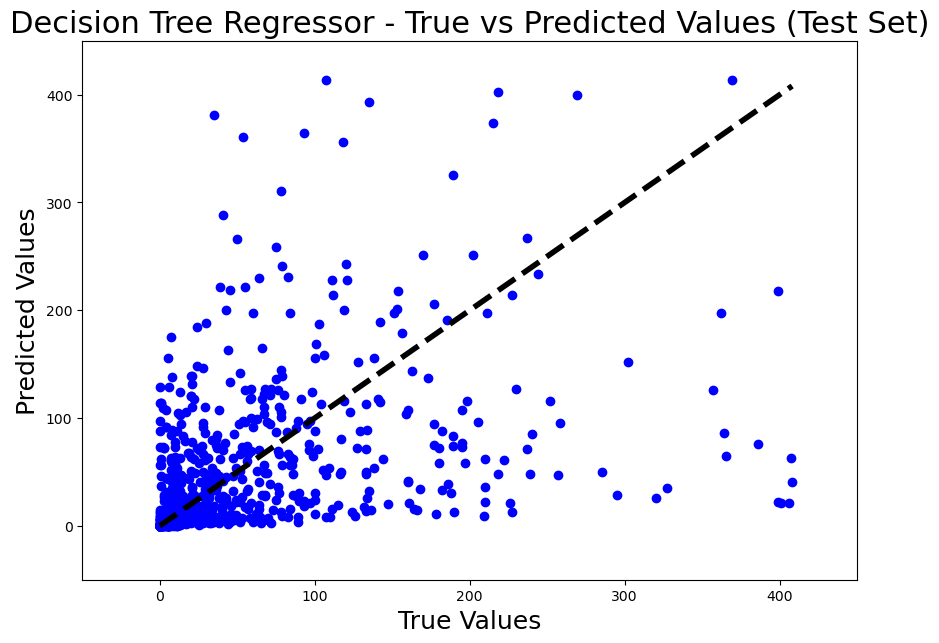

Random Forest Regressor
Feature Importances:
╭─────────────────────────┬──────────────╮
│ Feature                 │   Importance │
├─────────────────────────┼──────────────┤
│ Trading_Frequency       │    0.19188   │
│ Average_Volume_USD      │    0.0435953 │
│ Average_DPM             │    0.0468033 │
│ Peak_Trading_Times      │    0.027936  │
│ Profit_Loss_Variability │    0.0401354 │
│ Average_Trade_Duration  │    0.0512303 │
│ Average_Commission      │    0.0290532 │
│ Average_Swaps           │    0.0531304 │
│ Average_Profit          │    0.0492204 │
│ average_net_deposit     │    0.055925  │
│ average_credit          │    0.0164808 │
│ Buy_Percentage          │    0.0396977 │
│ TP/SL Hit Ratio         │    0.221167  │
│ Reward_Risk_Ratio       │    0.0296317 │
│ Ratio_Profitable_Trades │    0.0495598 │
│ country                 │    0.0296771 │
│ account_currency        │    0.014686  │
│ Trading_Method          │    0.010191  │
╰─────────────────────────┴──────────────╯
╭────────

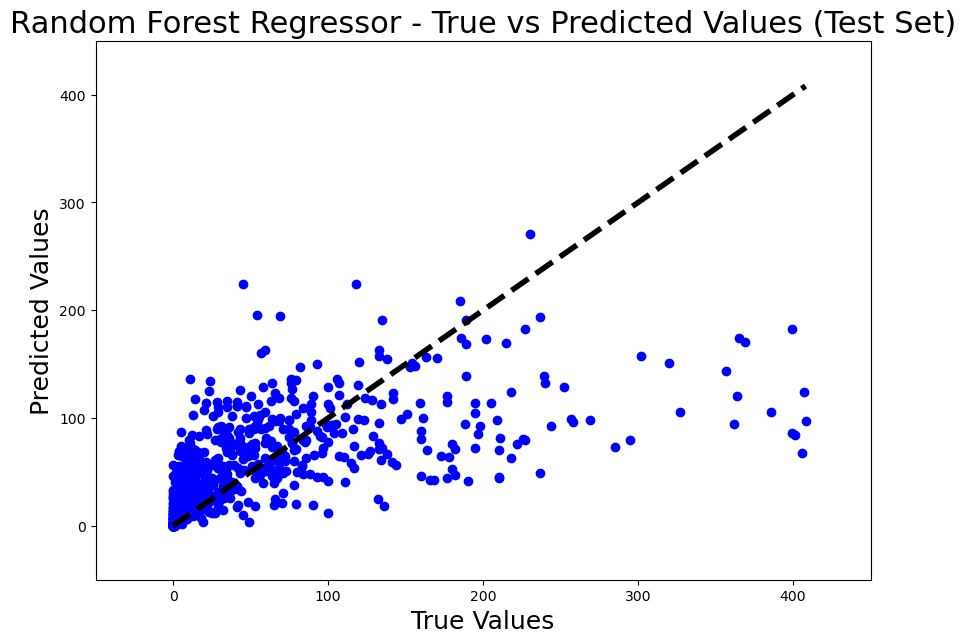

XGBoost Regressor
Feature Importances:
╭─────────────────────────┬──────────────╮
│ Feature                 │   Importance │
├─────────────────────────┼──────────────┤
│ Trading_Frequency       │    0.0700302 │
│ Average_Volume_USD      │    0.0239279 │
│ Average_DPM             │    0.0381206 │
│ Peak_Trading_Times      │    0.0245509 │
│ Profit_Loss_Variability │    0.0380975 │
│ Average_Trade_Duration  │    0.0282853 │
│ Average_Commission      │    0.0780488 │
│ Average_Swaps           │    0.0531525 │
│ Average_Profit          │    0.0505677 │
│ average_net_deposit     │    0.0473417 │
│ average_credit          │    0.0242025 │
│ Buy_Percentage          │    0.035901  │
│ TP/SL Hit Ratio         │    0.238429  │
│ Reward_Risk_Ratio       │    0.0637281 │
│ Ratio_Profitable_Trades │    0.0441561 │
│ country                 │    0.0417311 │
│ account_currency        │    0.040572  │
│ Trading_Method          │    0.059157  │
╰─────────────────────────┴──────────────╯
╭──────────────

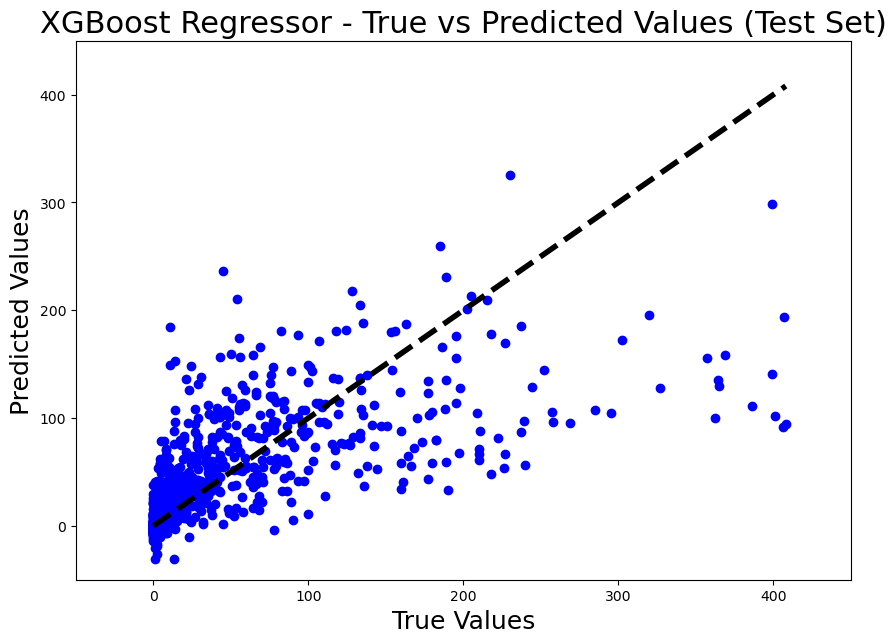

Neural Network Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   49.6169 │
│ Mean Squared Error (MSE)       │ 6795.87   │
│ Root Mean Squared Error (RMSE) │   82.4371 │
│ R-squared (R2)                 │   -0.1788 │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   45.7762 │
│ Mean Squared Error (MSE)       │ 4988.85   │
│ Root Mean Squared Error (RMSE) │   70.6318 │
│ R-squared (R2)                 │    0.0211 │
╰────────────────────────────────┴───────────╯



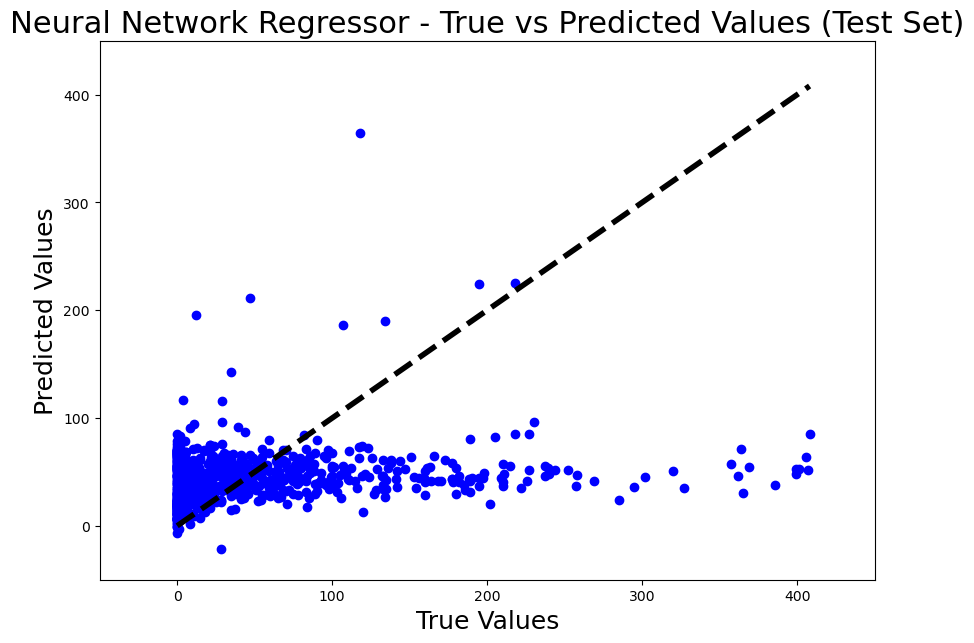

Linear Regression
Feature Coefficients:
╭─────────────────────────┬───────────────╮
│ Feature                 │   Coefficient │
├─────────────────────────┼───────────────┤
│ Trading_Frequency       │  -0.00241511  │
│ Average_Volume_USD      │   0.0138857   │
│ Average_DPM             │  -0.193279    │
│ Peak_Trading_Times      │   8.32662     │
│ Profit_Loss_Variability │   0.246895    │
│ Average_Trade_Duration  │   1.51964     │
│ Average_Commission      │   0.152339    │
│ Average_Swaps           │   0.000904336 │
│ Average_Profit          │  -0.0166178   │
│ average_net_deposit     │  -0.110407    │
│ average_credit          │   0.0271671   │
│ Buy_Percentage          │   0.135382    │
│ TP/SL Hit Ratio         │   0.0371475   │
│ Reward_Risk_Ratio       │  -0.0114829   │
│ Ratio_Profitable_Trades │  31.7177      │
│ country                 │  -0.0412977   │
│ account_currency        │  -6.67        │
│ Trading_Method          │   4.74101     │
╰─────────────────────────┴─────────

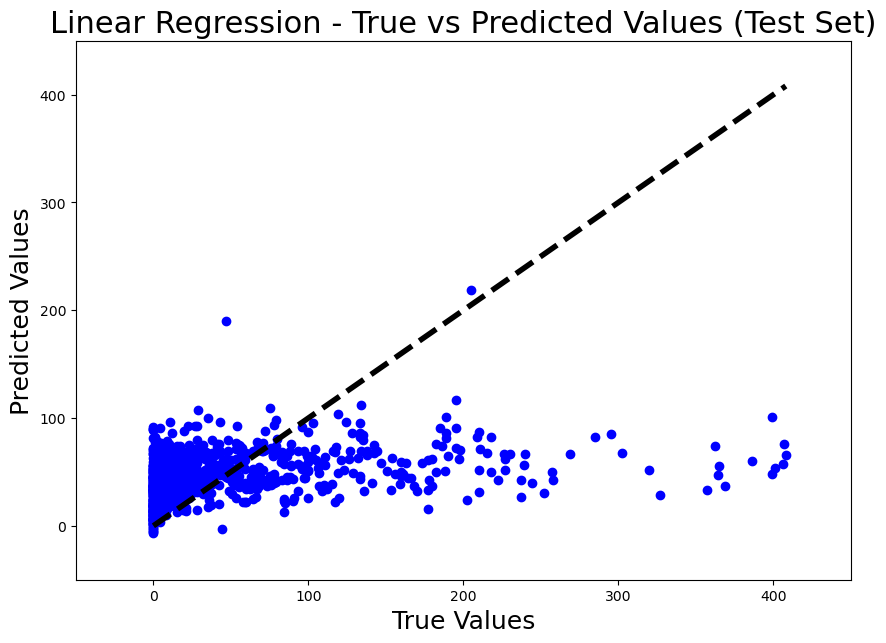

Ridge Regression
Feature Coefficients:
╭─────────────────────────┬───────────────╮
│ Feature                 │   Coefficient │
├─────────────────────────┼───────────────┤
│ Trading_Frequency       │  -0.00242398  │
│ Average_Volume_USD      │   0.0138831   │
│ Average_DPM             │  -0.191834    │
│ Peak_Trading_Times      │   8.3247      │
│ Profit_Loss_Variability │   0.246891    │
│ Average_Trade_Duration  │   1.51938     │
│ Average_Commission      │   0.152359    │
│ Average_Swaps           │   0.000898525 │
│ Average_Profit          │  -0.0165107   │
│ average_net_deposit     │  -0.110244    │
│ average_credit          │   0.0271689   │
│ Buy_Percentage          │   0.135422    │
│ TP/SL Hit Ratio         │   0.0371951   │
│ Reward_Risk_Ratio       │  -0.011481    │
│ Ratio_Profitable_Trades │  31.6051      │
│ country                 │  -0.0413155   │
│ account_currency        │  -6.67013     │
│ Trading_Method          │   4.74178     │
╰─────────────────────────┴──────────

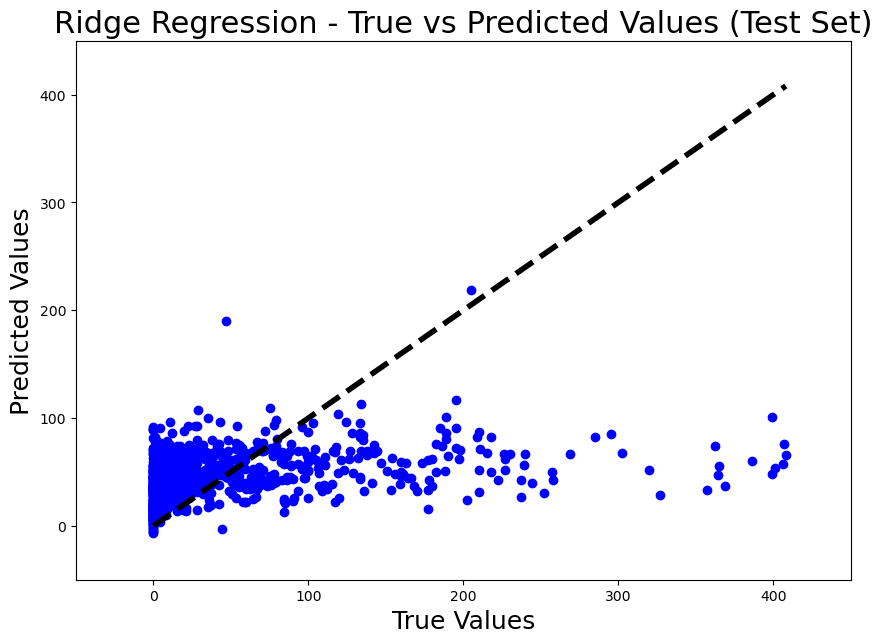

Lasso Regression
Feature Coefficients:
╭─────────────────────────┬───────────────╮
│ Feature                 │   Coefficient │
├─────────────────────────┼───────────────┤
│ Trading_Frequency       │  -0.00341513  │
│ Average_Volume_USD      │   0.010987    │
│ Average_DPM             │  -0           │
│ Peak_Trading_Times      │   6.5105      │
│ Profit_Loss_Variability │   0.243774    │
│ Average_Trade_Duration  │   1.39773     │
│ Average_Commission      │   0.0707403   │
│ Average_Swaps           │   0.000356284 │
│ Average_Profit          │  -0.00281633  │
│ average_net_deposit     │  -0.079939    │
│ average_credit          │   0.027697    │
│ Buy_Percentage          │   0.142128    │
│ TP/SL Hit Ratio         │   0.0418684   │
│ Reward_Risk_Ratio       │  -0.0111022   │
│ Ratio_Profitable_Trades │  17.7935      │
│ country                 │  -0.0476595   │
│ account_currency        │  -6.61462     │
│ Trading_Method          │   3.93006     │
╰─────────────────────────┴──────────

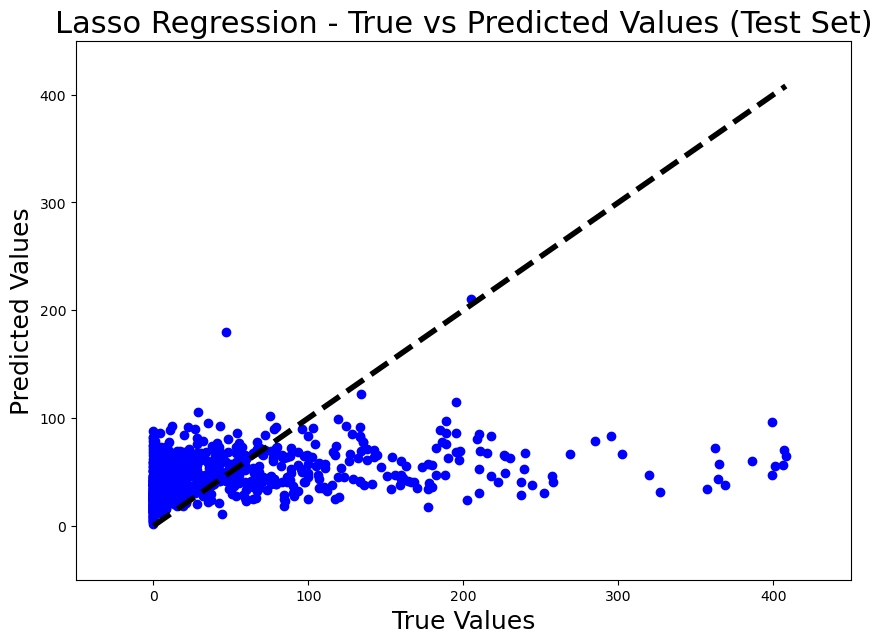

KNeighbors Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   39.5746 │
│ Mean Squared Error (MSE)       │ 4993.33   │
│ Root Mean Squared Error (RMSE) │   70.6635 │
│ R-squared (R2)                 │    0.1339 │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   37.962  │
│ Mean Squared Error (MSE)       │ 4138.6    │
│ Root Mean Squared Error (RMSE) │   64.3319 │
│ R-squared (R2)                 │    0.1879 │
╰────────────────────────────────┴───────────╯



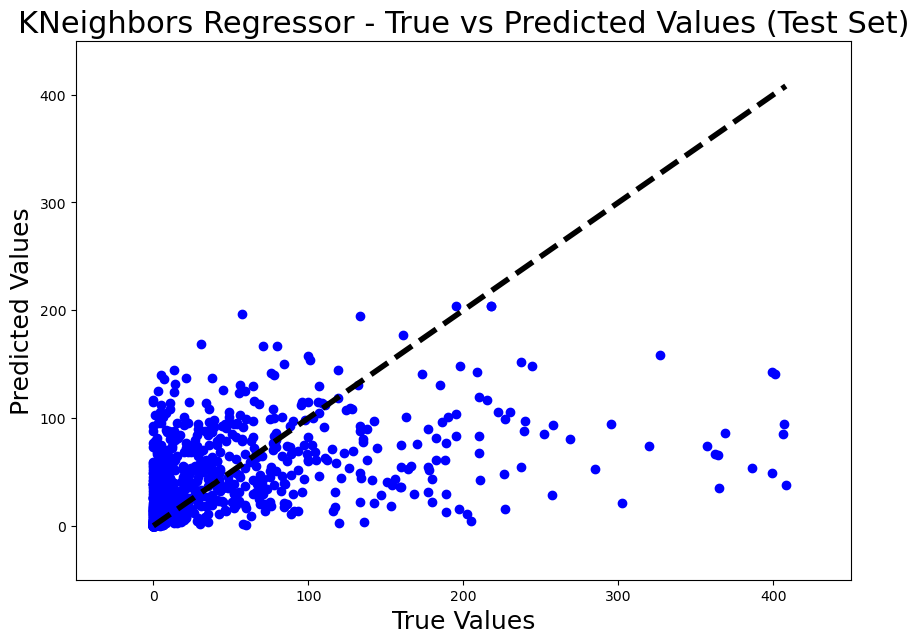

Support Vector Regressor
Feature importance or coefficients not available for this model.
╭────────────────────────────────┬───────────╮
│ Validation                     │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   44.8846 │
│ Mean Squared Error (MSE)       │ 6839.07   │
│ Root Mean Squared Error (RMSE) │   82.6987 │
│ R-squared (R2)                 │   -0.1863 │
╰────────────────────────────────┴───────────╯

╭────────────────────────────────┬───────────╮
│ Testing                        │     Value │
├────────────────────────────────┼───────────┤
│ Mean Absolute Error (MAE)      │   41.6189 │
│ Mean Squared Error (MSE)       │ 5940.81   │
│ Root Mean Squared Error (RMSE) │   77.0766 │
│ R-squared (R2)                 │   -0.1657 │
╰────────────────────────────────┴───────────╯



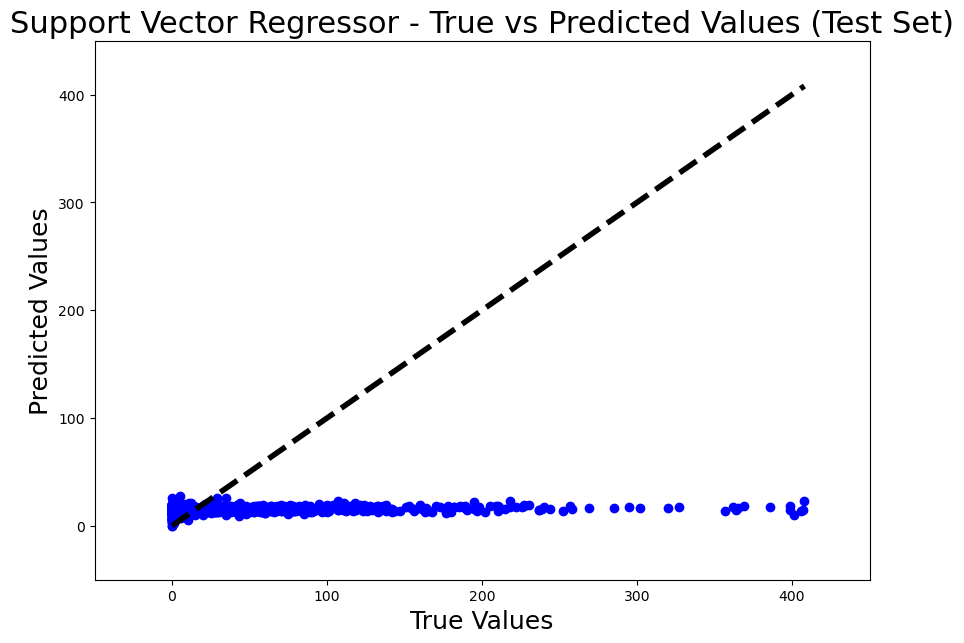

In [124]:
# Train and evaluate regression models
for name, model in regression_models.items():
    print(f"{name}")
    # Train the model on the training set
    model.fit(X_train, y_train)

    DisplayFeatureImportanceOrCoefficients(model)

    # Evaluate Metrics on Model
    DisplayMetrics(model, X_val, y_val, "Validation")
    y_test_pred = DisplayMetrics(model, X_test, y_test, "Testing")

    PerformPlot(name, y_test_pred)

    # Save the trained model to a file
    joblib.dump(model, f'Webpage/SavedModels/{name.replace(" ", "_")}_model.pkl')